In [4]:
# 전체 코드: RandomForest로 최고기온/최저기온 예측 후 일교차 계산 (2026년 가을 기준)

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import numpy as np

# 1. 데이터 불러오기 및 전처리
file_path = "./weather_data_all.csv"
df = pd.read_csv(file_path)
df["일시"] = pd.to_datetime(df["일시"])
df["month"] = df["일시"].dt.month
df["day"] = df["일시"].dt.day
df["dayofyear"] = df["일시"].dt.dayofyear

# 2. 사용할 특성 및 타겟
features = ["month", "day", "dayofyear", "평균기온(°C)", "평균 지면온도(°C)"]
target_cols = ["최고기온(°C)", "최저기온(°C)"]
df_model = df[["지점명", "일시"] + features + target_cols].dropna()

# 3. 예측 대상 날짜 (2026년 가을)
future_dates = pd.date_range(start="2026-09-01", end="2026-11-30")
future_df = pd.DataFrame({"일시": future_dates})
future_df["month"] = future_df["일시"].dt.month
future_df["day"] = future_df["일시"].dt.day
future_df["dayofyear"] = future_df["일시"].dt.dayofyear

# 4. 지점별 모델 학습 및 예측
results = []

for station in df_model["지점명"].unique():
    station_df = df_model[df_model["지점명"] == station].copy()
    
    # 평균 입력값 생성
    avg_temp = station_df["평균기온(°C)"].mean()
    avg_ground = station_df["평균 지면온도(°C)"].mean()

    future_station = future_df.copy()
    future_station["지점명"] = station
    future_station["평균기온(°C)"] = avg_temp
    future_station["평균 지면온도(°C)"] = avg_ground

    # 입력값 및 결측치 처리
    X = station_df[features]
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    # 최고기온 예측
    model_max = RandomForestRegressor(n_estimators=100, random_state=42)
    model_max.fit(X_imputed, station_df["최고기온(°C)"])
    X_future = imputer.transform(future_station[features])
    future_station["예측 최고기온(°C)"] = model_max.predict(X_future)

    # 최저기온 예측
    model_min = RandomForestRegressor(n_estimators=100, random_state=42)
    model_min.fit(X_imputed, station_df["최저기온(°C)"])
    future_station["예측 최저기온(°C)"] = model_min.predict(X_future)

    # 일교차 계산
    future_station["예측 일교차(°C)"] = (
        future_station["예측 최고기온(°C)"] - future_station["예측 최저기온(°C)"]
    )
    future_station["일교차10도이상"] = (future_station["예측 일교차(°C)"] >= 10).astype(int)

    results.append(future_station)

# 5. 결과 통합 및 요약
forecast_gap_df = pd.concat(results, ignore_index=True)
gap_summary = forecast_gap_df.groupby("지점명")["일교차10도이상"].sum().reset_index()
gap_summary.columns = ["지점명", "일교차10도 이상 예측일 수"]


gap_summary


,지점명,일교차10도 이상 예측일 수
0,고산,0
1,서귀포,0
2,성산,0
3,제주,0


In [6]:
# 평균기온 없이 최고기온과 최저기온을 예측하는 모델 구축 (평균기온 제거)

# 사용 컬럼 재정의 (평균기온 제거)
features_no_avg_temp = ["month", "day", "dayofyear", "평균 지면온도(°C)"]

# 데이터 필터링
df_model_no_avg = df[["지점명", "일시"] + features_no_avg_temp + target_cols].dropna()

# 예측 대상 날짜: 2026년 가을
future_df = pd.DataFrame({"일시": pd.date_range(start="2026-09-01", end="2026-11-30")})
future_df["month"] = future_df["일시"].dt.month
future_df["day"] = future_df["일시"].dt.day
future_df["dayofyear"] = future_df["일시"].dt.dayofyear

# 결과 저장
results = []

# 지점별 모델링 및 예측
for station in df_model_no_avg["지점명"].unique():
    station_df = df_model_no_avg[df_model_no_avg["지점명"] == station].copy()

    # 평균 지면온도만 활용
    avg_ground = station_df["평균 지면온도(°C)"].mean()
    future_station = future_df.copy()
    future_station["지점명"] = station
    future_station["평균 지면온도(°C)"] = avg_ground

    # 입력값 및 결측치 처리
    X = station_df[features_no_avg_temp]
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    # 최고기온 예측
    model_max = RandomForestRegressor(n_estimators=100, random_state=42)
    model_max.fit(X_imputed, station_df["최고기온(°C)"])
    X_future = imputer.transform(future_station[features_no_avg_temp])
    future_station["예측 최고기온(°C)"] = model_max.predict(X_future)

    # 최저기온 예측
    model_min = RandomForestRegressor(n_estimators=100, random_state=42)
    model_min.fit(X_imputed, station_df["최저기온(°C)"])
    future_station["예측 최저기온(°C)"] = model_min.predict(X_future)

    # 일교차 계산
    future_station["예측 일교차(°C)"] = (
        future_station["예측 최고기온(°C)"] - future_station["예측 최저기온(°C)"]
    )
    future_station["일교차10도이상"] = (future_station["예측 일교차(°C)"] >= 10).astype(int)

    results.append(future_station)

# 결과 병합
forecast_gap_df_no_avg = pd.concat(results, ignore_index=True)

# 요약
gap_summary_no_avg = forecast_gap_df_no_avg.groupby("지점명")["일교차10도이상"].sum().reset_index()
gap_summary_no_avg.columns = ["지점명", "일교차10도 이상 예측일 수"]


gap_summary_no_avg


,지점명,일교차10도 이상 예측일 수
0,고산,0
1,서귀포,0
2,성산,0
3,제주,0


C:\Users\MINJUN\AppData\Local\Temp\ipykernel_48076\3822403354.py:77: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_48076\3822403354.py:77: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_48076\3822403354.py:77: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_48076\3822403354.py:77: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_48076\3822403354.py:77: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MINJUN\AppData\Local\Temp\ipykernel_48076\3822403354.py:77: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) mi

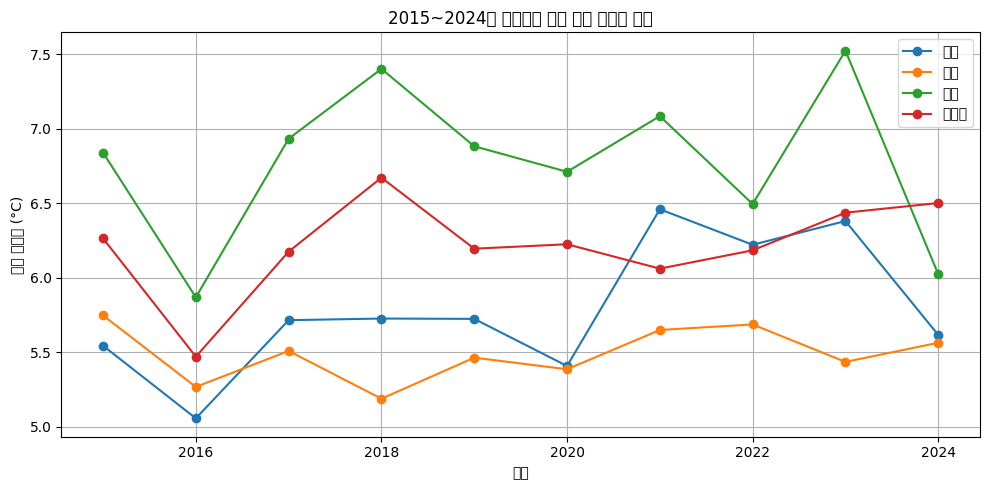

,지점명,일교차10도 이상 예측일 수
0,고산,0
1,서귀포,0
2,성산,0
3,제주,0


In [8]:
import matplotlib.pyplot as plt

# 1. 풍속, 일사량, 기압, 강수량 등 추가한 모델 개선
# 사용 컬럼 정의
extended_features = [
    "month", "day", "dayofyear", "평균 지면온도(°C)",
    "평균 풍속(m/s)", "합계 일사량(MJ/m2)", "평균 해면기압(hPa)"
]

# 결측치 제거
df_extended = df[["지점명", "일시", "최고기온(°C)", "최저기온(°C)"] + extended_features].dropna()

# 예측 대상 날짜 생성
future_df = pd.DataFrame({"일시": pd.date_range(start="2026-09-01", end="2026-11-30")})
future_df["month"] = future_df["일시"].dt.month
future_df["day"] = future_df["일시"].dt.day
future_df["dayofyear"] = future_df["일시"].dt.dayofyear

# 결과 저장
results = []

# 지점별 예측
for station in df_extended["지점명"].unique():
    station_df = df_extended[df_extended["지점명"] == station].copy()

    # 평균 입력값 생성
    future_station = future_df.copy()
    future_station["지점명"] = station
    for col in extended_features:
        future_station[col] = station_df[col].mean()

    # 입력 및 예측
    X = station_df[extended_features]
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    # 최고기온 예측
    model_max = RandomForestRegressor(n_estimators=100, random_state=42)
    model_max.fit(X_imputed, station_df["최고기온(°C)"])
    X_future = imputer.transform(future_station[extended_features])
    future_station["예측 최고기온(°C)"] = model_max.predict(X_future)

    # 최저기온 예측
    model_min = RandomForestRegressor(n_estimators=100, random_state=42)
    model_min.fit(X_imputed, station_df["최저기온(°C)"])
    future_station["예측 최저기온(°C)"] = model_min.predict(X_future)

    # 일교차 계산
    future_station["예측 일교차(°C)"] = (
        future_station["예측 최고기온(°C)"] - future_station["예측 최저기온(°C)"]
    )
    future_station["일교차10도이상"] = (future_station["예측 일교차(°C)"] >= 10).astype(int)

    results.append(future_station)

# 병합
forecast_gap_extended = pd.concat(results, ignore_index=True)
gap_summary_extended = forecast_gap_extended.groupby("지점명")["일교차10도이상"].sum().reset_index()
gap_summary_extended.columns = ["지점명", "일교차10도 이상 예측일 수"]

# 2. 실제 과거 데이터 기반 평균 일교차 시각화 (2015~2024년)
past_fall = df[(df["일시"].dt.month >= 9) & (df["일시"].dt.month <= 11) & (df["일시"].dt.year < 2025)].copy()
past_fall["일교차(°C)"] = past_fall["최고기온(°C)"] - past_fall["최저기온(°C)"]
past_fall["연도"] = past_fall["일시"].dt.year

# 연도별 평균 일교차 시각화
plt.figure(figsize=(10, 5))
for station in past_fall["지점명"].unique():
    avg_gap_by_year = past_fall[past_fall["지점명"] == station].groupby("연도")["일교차(°C)"].mean()
    plt.plot(avg_gap_by_year.index, avg_gap_by_year.values, marker='o', label=station)

plt.title("2015~2024년 제주지역 가을 평균 일교차 추이")
plt.xlabel("연도")
plt.ylabel("평균 일교차 (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


gap_summary_extended
